# VAM Tutorial (Simple)

::: {.callout-note title="Reference"}
The following the model is described in the paper: 

```
 @article{Escalante_2024, 
    title={Vertically averaged and moment equations: New derivation, efficient numerical solution and comparison with other physical approximations for modeling non-hydrostatic free surface flows}, 
    volume={504}, 
    ISSN={00219991}, 
    DOI={10.1016/j.jcp.2024.112882}, 
    journal={Journal of Computational Physics}, 
    author={Escalante, C. and Morales De Luna, T. and Cantero-Chinchilla, F. and Castro-Orgaz, O.}, 
    year={2024}, 
    month=may, 
    pages={112882}, 
    language={en} 
}
```

:::



## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi, symbols, Derivative, Function, exp, I, Rational, Derivative, init_printing, Matrix, sqrt, diff
from time import time as gettime
from attr import define, field
from typing import Callable
from functools import partial


from library.zoomy_core.fvm.solver_jax import HyperbolicSolver, PoissonSolver, Settings
from library.zoomy_core.fvm.ode import RK1
import library.zoomy_core.fvm.reconstruction as recon
import library.zoomy_core.fvm.timestepping as timestepping
import library.zoomy_core.fvm.flux as flux
import library.zoomy_core.fvm.nonconservative_flux as nc_flux
from library.zoomy_core.model.boundary_conditions import BoundaryCondition
from library.zoomy_core.model.models.basisfunctions import Basisfunction, Legendre_shifted
from library.zoomy_core.model.models.basismatrices import Basismatrices
from library.zoomy_core.model.basemodel import (
    register_sympy_attribute,
)
from library.zoomy_core.fvm.solver_jax import newton_solver, log_callback_hyperbolic, log_callback_execution_time
from library.zoomy_core.fvm.ode import RK1


from library.zoomy_core.model.basemodel import Model
from library.zoomy_core.misc.misc import Zstruct
import library.zoomy_core.model.initial_conditions as IC
import library.zoomy_core.model.boundary_conditions as BC
import library.zoomy_core.misc.io as io
from library.zoomy_core.mesh.mesh import compute_derivatives
from tests.pdesoft import plots_paper
import library.zoomy_core.model.analysis as analysis

import library.zoomy_core.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.zoomy_core.mesh.mesh import convert_mesh_to_jax
import argparse

init_printing(use_latex=True)

2025-08-08 13:22:21.919 | WARNING  | library.core.fvm.solver_jax:<module>:28 - No module named 'precice'


## Model definition

In [2]:
@define(frozen=True, slots=True, kw_only=True)
class VAMHyperbolic(Model):
    dimension: int = field(init=False, default=1)
    variables: Zstruct = field(init=False, default=6)
    aux_variables: Zstruct = field(factory=lambda: ['hw2', 'p0', 'p1', 'dbdx', 'dhdx', 'dhp0dx', 'dhp1dx'])
    _default_parameters: dict = field(
        init=False,
        factory=lambda: {"g": 9.81}
        )

    def flux(self):
        fx = Matrix([0 for i in range(self.n_variables)])
        hw2 = self.aux_variables.hw2
        h = self.variables[0]
        hu0 = self.variables[1]
        hu1 = self.variables[2]
        hw0 = self.variables[3]
        hw1 = self.variables[4]
        u0 = hu0 / h
        u1 = hu1 / h
        w0 = hw0 / h
        w1 = hw1 / h
        
        fx[0] = hu0
        fx[1] = hu0 * u0 + 1/3 * hu1 * u1
        fx[2] = 2*hu0 * u1
        fx[3] = hu0 * w0 + 1/3 * hu1 * w1
        fx[4] = hu0 * w1 + u1 * (hw0 + 2/5*hw2)
        
        return [fx]

    def nonconservative_matrix(self):
        nc = Matrix([[0 for i in range(self.n_variables)] for j in range(self.n_variables)])

        hw2 = self.aux_variables.hw2
        h = self.variables[0]
        hu0 = self.variables[1]
        hw0 = self.variables[3]
        param = self.parameters

        u0 = hu0 / h
        w0 = hw0 / h
        w2 = hw2 / h

        nc[1, 0] = param.g * h
        nc[1, 5] = param.g * h
        nc[2, 2] = -u0
        nc[4, 2] = + 1/5 * w2 - w0
        return [nc]
    
    def eigenvalues(self):
        ev = Matrix([0 for i in range(self.n_variables)])
        h = self.variables[0]
        hu0 = self.variables[1]
        hu1 = self.variables[2]
        param = self.parameters

        u0 = hu0 / h
        u1 = hu1 / h

        ev[0] = u0
        ev[1] = u0 + 1/sqrt(3) * u1
        ev[2] = u0 - 1/sqrt(3) * u1
        ev[3] = u0 + sqrt(param.g * h + u1**2)
        ev[4] = u0 - sqrt(param.g * h + u1**2)
        ev[5] = 0
        
        return ev

    def source(self):
        R = Matrix([0 for i in range(self.n_variables)])
        
        p0 = self.aux_variables.p0
        p1 = self.aux_variables.p1
        dbdx = self.aux_variables.dbdx
        dhdx = self.aux_variables.dhdx
        dhp0dx = self.aux_variables.dhp0dx
        dhp1dx = self.aux_variables.dhp1dx

        R[0] = 0
        R[1] = dhp0dx + 2 * p1 * dbdx 
        R[2] = dhp1dx - (3*p0 - p1)*dhdx  -6*(p0-p1)*dbdx
        R[3] = -2*p1
        R[4] = 6*(p0-p1)
        R[5] = 0
        return -R
        
    def constraints(self):
        C = Matrix([0 for i in range(3)])
        
        x = self.position[0]
        q0 = self.variables[0]
        q1 = self.variables[1]
        q2 = self.variables[2]
        q3 = self.variables[3]
        q4 = self.variables[4]
        q5 = self.variables[5]
        h = q0
        u0 = q1/h
        u1 = q2/h
        w0 = q3/h
        w1 = q4/h
        b = q5
        w2 = self.aux_variables.hw2 / q0
        
        C[0] = h * Derivative(u0, x) + Rational(1,3) * Derivative(h*u1, x) + Rational(1,3) * u1 * Derivative(h, x) + 2*(w0 - u0 * Derivative(b, x)) 
        C[1] = h * Derivative(u0, x) + u1 * Derivative(h, x) + 2*(u1 * Derivative(b,x) - w1)
        C[2] = h * Derivative(u0, x) + u1 * Derivative(h, x) + 2*(w0 + w2 - u0 *  Derivative(b, x))
        return C
        
        
        

In [ ]:
@define(frozen=True, slots=True, kw_only=True)
class VAMPoisson(Model):
    
    dimension: int = field(init=False, default=1)
    variables: Zstruct = field(init=False, factory=lambda: ['p0', 'p1'])
    aux_variables: Zstruct = field(factory=lambda: ['dp0dx', 'ddp0dxx', 'dp1dx', 'ddp1dxx', 'd4p0dx4', 'd4p1dx4', 'h', 'dbdx', 'ddbdxx', 'dhdx', 'ddhdxx', 'u0', 'du0dx', 'w0', 'w1', 'u1', 'du1dx', 'dt'])
    _default_parameters: dict = field(
        init=False,
        factory=lambda: {"g": 9.81}
        )
    

    def residual(self):
        R = Matrix([0 for i in range(self.n_variables)])

        h = self.aux_variables.h
        p0 = self.variables.p0
        p1 = self.variables.p1
        dt = self.aux_variables.dt

        dbdx   = self.aux_variables.dbdx
        ddbdxx = self.aux_variables.ddbdxx

        dhdx   = self.aux_variables.dhdx
        ddhdxx = self.aux_variables.ddhdxx
        
        dp0dx = self.aux_variables.dp0dx
        dp1dx = self.aux_variables.dp1dx
        ddp0dxx = self.aux_variables.ddp0dxx
        ddp1dxx = self.aux_variables.ddp1dxx

        
        #Note, these are not truly the values from the old time step, but rather the values from the middle state after the hyperbolic step
        oldu0 = self.aux_variables.u0
        doldu0dx = self.aux_variables.du0dx
        oldw1 = self.aux_variables.w1
        oldw0 = self.aux_variables.w0
        oldu1 = self.aux_variables.u1
        doldu1dx = self.aux_variables.du1dx

        I1 = -1/3*dt*(-(3*p0 - p1)*ddhdxx - (6*p0 - 6*p1)*ddbdxx - (3*dp0dx - dp1dx)*dhdx - (6*dp0dx - 6*dp1dx)*dbdx + h*ddp1dxx + p1*ddhdxx + 2*dhdx*dp1dx) - 2*(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dbdx/h + 1/3*(-dt*(-(3*p0 - p1)*dhdx - (6*p0 - 6*p1)*dbdx + h*dp1dx + p1*dhdx) + h*oldu1)*dhdx/h + 2*(2*dt*p1 + h*oldw0)/h + (-(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dhdx/h**2 + (-dt*(h*ddp0dxx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp1dx + 2*dhdx*dp0dx) + h*doldu0dx + oldu0*dhdx)/h)*h + 1/3*h*doldu1dx + 1/3*oldu1*dhdx
        I2 =-2*(-dt*(6*p0 - 6*p1) + h*oldw1)/h + 2*(-dt*(-(3*p0 - p1)*dhdx - (6*p0 - 6*p1)*dbdx + h*dp1dx + p1*dhdx) + h*oldu1)*dbdx/h + (-dt*(-(3*p0 - p1)*dhdx - (6*p0 - 6*p1)*dbdx + h*dp1dx + p1*dhdx) + h*oldu1)*dhdx/h + (-(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dhdx/h**2 + (-dt*(h*ddp0dxx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp1dx + 2*dhdx*dp0dx) + h*doldu0dx + oldu0*dhdx)/h)*h 
        R[0] = I1 
        R[1] = I2

        return R
    
    def eigenvalues(self):
        ev = Matrix([0 for i in range(self.n_variables)])
        return ev


In [3]:
model = VAMHyperbolic(boundary_conditions=BC.BoundaryConditions.dummy())

## Linear stability analysis

In [4]:

analyzer = analysis.ModelAnalyser(model)
h0, b0 = symbols('h_c b_c')
eps = analyzer.get_eps()
h, u0, u1, w0, w1, w2, p0, p1 = analyzer.create_functions_from_list(['h', 'u_0', 'u_1', 'w_0', 'w_1', 'w_2', 'p_0', 'p_1'])
t, x, y, z = analyzer.get_time_space()
Q = Matrix([h0 + eps * h, (h0 + eps * h) * eps * u0, (h0 + eps * h) * eps * u1, (h0 + eps * h) * eps * w0, (h0 + eps * h)* eps * w1, b0])
Qaux = Matrix([(h0 + eps * h) * eps*w2, eps*p0, eps*p1, diff(b0, x), diff(h0 + eps * h, x), diff((h0 + eps * h) * eps * p0, x), diff((h0 + eps * h) * eps * p1, x)])

linearized_system = analyzer.linearize_system(Q, Qaux, constraints = model.constraints())

In [5]:
analyzer.print_equations()

<IPython.core.display.Latex object>

In [6]:
linearized_system = analyzer.delete_equations([5])

In [7]:
analyzer.print_equations()

<IPython.core.display.Latex object>

In [8]:
analyzer.insert_plane_wave_ansatz([h, u0, u1, w0, w1])

In [9]:
analyzer.print_equations()

<IPython.core.display.Latex object>

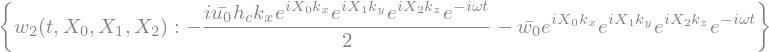

In [10]:
analyzer.solve_for_constraints([3, 4, 7], [p0, p1, w2])

In [11]:
analyzer.print_equations()

<IPython.core.display.Latex object>

In [12]:
analyzer.remove_exponential()

In [13]:
analyzer.print_equations()

<IPython.core.display.Latex object>

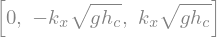

In [14]:
dispersion_relation = analyzer.solve_for_dispersion_relation()
dispersion_relation

In [15]:
group_velocity = dispersion_relation[1]**2 / model.parameters.g / h0
group_velocity

## Numerical solution

### Solver definitions

In [ ]:

@define(frozen=True, slots=True, kw_only=True)            
class PredictorCorrectorSolver(HyperbolicSolver):
    settings: Zstruct = field(factory=lambda: Settings.default())
    compute_dt: Callable = field(factory=lambda: timestepping.adaptive(CFL=0.9))
    num_flux: Callable = field(factory=lambda: flux.Zero())
    nc_flux: Callable = field(factory=lambda: nc_flux.segmentpath())
    pressuresolver: Callable = field(factory=lambda: PoissonSolver())
    time_end: float = 0.1
    
    def map_Q_to_P(self, Q, Qaux, P, Paux, mesh, dt):
        h = Q[0]
        u0 = Q[1]/h
        u1 = Q[2]/h
        w0 = Q[3]/h
        w1 = Q[4]/h
        b = Q[5]
        
        dbdx = Qaux[3]
        ddbdxx = compute_derivatives(b, mesh, derivatives_multi_index=([[2]]))[:, 0]
        dhdx = Qaux[4]
        ddhdxx = compute_derivatives(h, mesh, derivatives_multi_index=([[2]]))[:, 0]
        du0dx = compute_derivatives(u0, mesh, derivatives_multi_index=([[1]]))[:, 0]
        du1dx = compute_derivatives(u1, mesh, derivatives_multi_index=([[1]]))[:, 0]

        offset = 2
        Paux = Paux.at[4+offset].set(h)
        Paux = Paux.at[5+offset].set(dbdx)
        Paux = Paux.at[6+offset].set(ddbdxx)
        Paux = Paux.at[7+offset].set(dhdx)
        Paux = Paux.at[8+offset].set(ddhdxx)
        Paux = Paux.at[9+offset].set(u0)
        Paux = Paux.at[10+offset].set(du0dx)
        Paux = Paux.at[11+offset].set(w0)        
        u0 = Q[1]/h
        u1 = Q[2]/h
        w0 = Q[3]/h
        w1 = Q[4]/h
        b = Q[5]
        
        dbdx = Qaux[3]
        ddbdxx = compute_derivatives(b, mesh, derivatives_multi_index=([[2]]))[:, 0]
        dhdx = Qaux[4]
        ddhdxx = compute_derivatives(h, mesh, derivatives_multi_index=([[2]]))[:, 0]
        du0dx = compute_derivatives(u0, mesh, derivatives_multi_index=([[1]]))[:, 0]
        du1dx = compute_derivatives(u1, mesh, derivatives_multi_index=([[1]]))[:, 0]

        offset = 2
        Paux = Paux.at[4+offset].set(h)
        Paux = Paux.at[5+offset].set(dbdx)
        Paux = Paux.at[6+offset].set(ddbdxx)
        Paux = Paux.at[7+offset].set(dhdx)
        Paux = Paux.at[8+offset].set(ddhdxx)
        Paux = Paux.at[9+offset].set(u0)
        Paux = Paux.at[10+offset].set(du0dx)
        Paux = Paux.at[11+offset].set(w0)
        Paux = Paux.at[12+offset].set(w1)
        Paux = Paux.at[13+offset].set(u1)
        Paux = Paux.at[14+offset].set(du1dx)
        Paux = Paux.at[15+offset].set(dt)
        return Paux
    
    def map_P_to_Q(self, Q, Qaux, P, Paux, mesh, dt):
        Qaux = Qaux.at[1].set(P[0])
        Qaux = Qaux.at[2].set(P[1])
        h =  Q[0]
        
        dhp0dx = compute_derivatives(h*P[0], mesh, derivatives_multi_index=([[1]]))[:, 0]
        dhp1dx = compute_derivatives(h*P[1], mesh, derivatives_multi_index=([[1]]))[:, 0]

        Qaux = Qaux.at[5].set(dhp0dx)
        Qaux = Qaux.at[6].set(dhp1dx)
        return Qaux
    
    
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):

        h=Q[0]
        hu0=Q[1]
        hu1=Q[2]
        hw0=Q[3]
        hw1=Q[4]
        b=Q[5]
        
        w0 = hw0 / h
        w1 = hw1 / h
        u0 = hu0 / h
        u1 = hu1 / h
        # aux_fields=['hw2', 'p0', 'p1', 'dbdx', 'dhdx', 'dhp0dx', 'dhp1dx'],

        dbdx  = compute_derivatives(b, mesh, derivatives_multi_index=([[1]]))[:,0]
        Qaux = Qaux.at[3].set(dbdx)
        
        hw2 = h*(-(w0 + w1) + (u0 + u1) * dbdx)
        Qaux = Qaux.at[0].set(hw2)
        
        
        dhdx   = compute_derivatives(h, mesh, derivatives_multi_index=([[1]]))[:, 0]
        Qaux = Qaux.at[4].set(dhdx)
        return Qaux
    
    # @partial(jax.jit, static_argnames=["self", "mesh", "pde"])
    def compute_source_pressure(self, mesh, model):
        @jax.jit
        def f(dt, Q, Qaux, parameters):
            dQ = jnp.zeros_like(Q)
            dQ = dQ.at[:, : mesh.n_inner_cells].set(
                model.residual(
                    Q[:, : mesh.n_inner_cells],
                    Qaux[:, : mesh.n_inner_cells],
                    parameters,
                )
            )
            return Q + dt * dQ
        return f
    
    def solve(self, mesh, model, pressure_model, write_output=True):
        modelP = pressure_model
        Q, Qaux = self.initialize(mesh, model)
        Q, Qaux, parameters, mesh, model = self.create_runtime(Q, Qaux, mesh, model)
        P, Paux = self.pressuresolver.initialize(mesh, modelP)
        P, Paux, parametersP, mesh, modelP = self.pressuresolver.create_runtime(P, Paux, mesh, modelP)
        
        if write_output:
            output_hdf5_path = os.path.join(
                self.settings.output.directory, f"{self.settings.output.filename}.h5"
            )
            save_fields = io.get_save_fields(output_hdf5_path)
        else:
            def skip_save(time, time_stamp, i_snapshot, Q, Qaux):
                return i_snapshot
            save_fields = skip_save

        def run(Q, Qaux, parameters, model, P, Paux, parametersP, modelP):
            iteration = 0.0
            time = 0.0
            assert model.dimension == mesh.dimension

            i_snapshot = 0.0
            dt_snapshot = self.time_end / (self.settings.output.snapshots - 1)
            if write_output:
                io.init_output_directory(
                    self.settings.output.directory, self.settings.output.clean_directory
                )
                mesh.write_to_hdf5(output_hdf5_path)
                io.save_settings(self.settings)
            i_snapshot = save_fields(time, 0.0, i_snapshot, Q, Qaux)

            Qnew = Q
            Qauxnew = Qaux
            

            min_inradius = jnp.min(mesh.cell_inradius)

            compute_max_abs_eigenvalue = self.get_compute_max_abs_eigenvalue(mesh, model)
            flux_operator = self.get_flux_operator(mesh, model)
            source_operator = self.get_compute_source(mesh, model)
            boundary_operator = self.get_apply_boundary_conditions(mesh, model)


            boundary_operatorP = self.get_apply_boundary_conditions(mesh, modelP)


            @jax.jit
            @partial(jax.named_call, name="time loop")
            def time_loop(time, iteration, i_snapshot, Qnew, Qaux, P, Paux):
                loop_val = (time, iteration, i_snapshot, Qnew, Qaux, P, Paux)

                @partial(jax.named_call, name="time_step")
                def loop_body(init_value):
                    time, iteration, i_snapshot, Qnew, Qauxnew, P, Paux = init_value
                    Q = Qnew
                    Qaux = Qauxnew

                    dt = self.compute_dt(
                        Q, Qaux, parameters, min_inradius, compute_max_abs_eigenvalue
                    )
                    def step(Q, Qaux, P, Paux):
                        Qnew = RK1(flux_operator, Q, Qaux, parameters, dt)
                        
                        ## TODO remove
                        Qnew = Qnew.at[5].set(Q[5])
                        Qnew = boundary_operator(time, Qnew, Qaux, parameters)
                        Qauxnew = self.update_qaux(Qnew, Qaux, Q, Qaux, mesh, model, parameters, time, dt)
                        
                        
                        
                        Paux = self.map_Q_to_P(Qnew, Qauxnew, P, Paux, mesh, dt)
                        Paux = self.pressuresolver.update_qaux(P, Paux, P, Paux, mesh, modelP, parametersP, time, dt)
                        residual = self.pressuresolver.get_residual(Paux, P, Paux, parametersP, mesh, modelP, boundary_operatorP, time, dt)
                        newton_solve = newton_solver(residual)
                        P = newton_solve(P)
                        Paux = self.pressuresolver.update_qaux(P, Paux, P, Paux, mesh, modelP, parametersP, time, dt)
                        
                        Qauxnew = self.map_P_to_Q(Qnew, Qauxnew, P, Paux, mesh, dt)
                        Qauxnew = self.update_qaux(Qnew, Qauxnew, Q, Qaux, mesh, model, parameters, time, dt)

                        Qnew = RK1(
                            source_operator,
                            Qnew,
                            Qauxnew,
                            parameters,
                            dt,
                        )

                        Qnew = boundary_operator(time, Qnew, Qauxnew, parameters)
                        return Qnew, Qauxnew
                    
                    Q1, Qaux1= step(Q, Qaux, P, Paux)
                    Q2, Qaux2= step(Q1, Qaux1, P, Paux)
                    Qnew = 0.5 * (Q2 + Q)
                    Qauxnew = 0.5 * (Qaux2 + Qaux)

                    
                    # Update solution and time
                    time += dt
                    iteration += 1

                    time_stamp = (i_snapshot) * dt_snapshot

                    i_snapshot = save_fields(time, time_stamp, i_snapshot, Qnew, Qauxnew)

                    
                    jax.experimental.io_callback(
                        log_callback_hyperbolic,                 
                        None,                          
                        iteration, time, dt, time_stamp 
                    )
                    

                    return (time, iteration, i_snapshot, Qnew, Qauxnew, P, Paux)

                def proceed(loop_val):
                    time, iteration, i_snapshot, Qnew, Qaux, P, Paux = loop_val
                    return time < self.time_end

                (time, iteration, i_snapshot, Qnew, Qaux, P, Paux) = jax.lax.while_loop(
                    proceed, loop_body, loop_val
                )

                return Qnew, Qauxnew

            Qnew = time_loop(time, iteration, i_snapshot, Qnew, Qaux, P, Paux)
            return Qnew, Qaux

        time_start = gettime()
        Qnew, Qaux = run(Q, Qaux, parameters, model, P, Paux, parametersP, modelP)
        jax.experimental.io_callback(
            log_callback_execution_time,                 
            None,                          
            gettime() - time_start 
        )
        return Qnew, Qaux
    

In [ ]:
class MyPoissonSolver(PoissonSolver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):

        p0 = Q[0]
        p1 = Q[1]
        
        dp0dx = compute_derivatives(p0, mesh, derivatives_multi_index=([[1]]))[:, 0]
        ddp0dxx = compute_derivatives(p0, mesh, derivatives_multi_index=([[2]]))[:, 0]
        dp1dx = compute_derivatives(p1, mesh, derivatives_multi_index=([[1]]))[:, 0]
        ddp1dxx = compute_derivatives(p1, mesh, derivatives_multi_index=([[2]]))[:, 0]


        Qaux = Qaux.at[0].set(dp0dx)
        Qaux = Qaux.at[1].set(ddp0dxx)
        Qaux = Qaux.at[2].set(dp1dx)
        Qaux = Qaux.at[3].set(ddp1dxx)

        return Qaux


### Simulation

In [19]:

settings = Settings(
    name="VAM",
    output = Zstruct(directory="outputs/vam", filename='vam')
)

bc_tags = ["left", "right"]
bc_tags_periodic_to = ["right", "left"]

bcs1 = BC.BoundaryConditions(
    [
        BC.Lambda(tag='left', prescribe_fields={
            1: lambda t, x, dx, q, qaux, p, n: .11197,
            2: lambda t, x, dx, q, qaux, p, n: 0.,
            3: lambda t, x, dx, q, qaux, p, n: 0.,
            4: lambda t, x, dx, q, qaux, p, n: 0.
        }),
        BC.Extrapolation(tag='right')

    ]
)

bcs2 = BC.BoundaryConditions(
    [
        BC.Extrapolation(tag='left'),
        BC.Extrapolation(tag='right'),
    ]
)

def custom_ic1(x):
    Q = np.zeros(6, dtype=float)
    Q[1] = np.where(x[0]-5 < 1, 0.0, 0.)
    Q[5] = 0.20*np.exp(-(x[0]-0.)**2 / (2*0.2**2)) 
    Q[0] = np.where(x[0] < 1, 0.34, 0.015) - Q[5]
    Q[0] = np.where(Q[0] > 0.015, Q[0], 0.015)
    # Q[0] = np.where(x[0]**2 < 0.5, 0.2, 0.1)
    return Q


ic1 = IC.UserFunction(custom_ic1)


model1 = VAMHyperbolic(
    boundary_conditions=bcs1,
    initial_conditions=ic1,
)

model2 = VAMPoisson(
    boundary_conditions=bcs2,
)

mesh = petscMesh.Mesh.create_1d((-1.5, 1.5), 60, lsq_degree=2)

solver = PredictorCorrectorSolver(time_end = 20, settings=settings, pressuresolver=MyPoissonSolver())

Q, Qaux = solver.solve(mesh, model1, model2, write_output=True)



2025-08-08 13:22:25.475 | WARNING  | library.core.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False
2025-08-08 13:22:38.181 | INFO     | library.core.fvm.solver_jax:log_callback_hyperbolic:43 - iteration: 1, time: 0.024640, dt: 0.024640, next write at time: 2.222222
2025-08-08 13:22:38.259 | INFO     | library.core.fvm.solver_jax:log_callback_hyperbolic:43 - iteration: 2, time: 0.046874, dt: 0.022234, next write at time: 2.222222
2025-08-08 13:22:38.291 | INFO     | library.core.fvm.solver_jax:log_callback_hyperbolic:43 - iteration: 3, time: 0.068065, dt: 0.021191, next write at time: 2.222222
2025-08-08 13:22:38.324 | INFO     | library.core.fvm.solver_jax:log_callback_hyperbolic:43 - iteration: 4, time: 0.088748, dt: 0.020682, next write at time: 2.222222
2025-08-08 13:22:38.360 | INFO     | library.core.fvm.solver_jax:log_callback_hyperbolic:43 - iteration: 5, time: 0.109165, dt: 0.020417, next write at time: 2.222222
2025-08-08 13:22:38

### Visualization

In [20]:
io.generate_vtk(os.path.join(settings.output.directory, f"{settings.output.filename}.h5"))

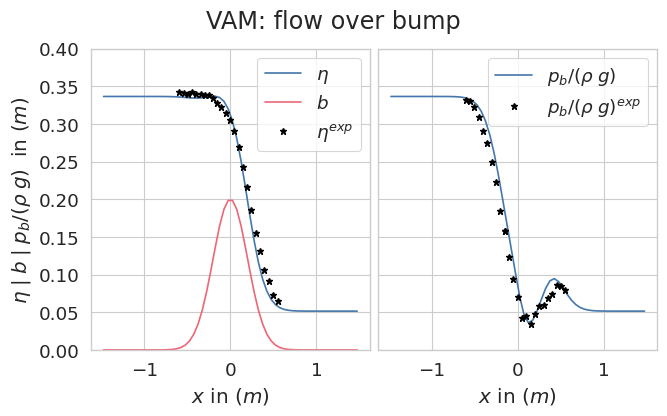

In [21]:
fig = plots_paper.plot_vam(os.path.join(settings.output.directory, settings.output.filename + ".h5"))